# Online Retail Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
from google.colab import files
upload = files.upload()

Saving online_retail_combined.csv to online_retail_combined.csv


In [3]:
f_data = pd.read_csv('online_retail_combined.csv')
f_data.head(6)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom


In [4]:
f_data.rename(columns={'Price': 'UnitPrice', 'Customer ID': 'Customer ID'}, inplace=True)

In [5]:
f_data['InvoiceDate'] = pd.to_datetime(f_data['InvoiceDate'], errors='coerce')
f_data['Quantity'] = pd.to_numeric(f_data['Quantity'], errors='coerce')
f_data['UnitPrice'] = pd.to_numeric(f_data['UnitPrice'], errors='coerce')
f_data = f_data.dropna(subset=['InvoiceDate', 'Quantity', 'UnitPrice'])
f_data['TotalSales'] = f_data['Quantity'] * f_data['UnitPrice']
f_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Customer ID,Country,TotalSales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [6]:
f_data['YearMonth'] = f_data['InvoiceDate'].dt.to_period('M')
monthly_sales = f_data.groupby('YearMonth')['TotalSales'].sum()

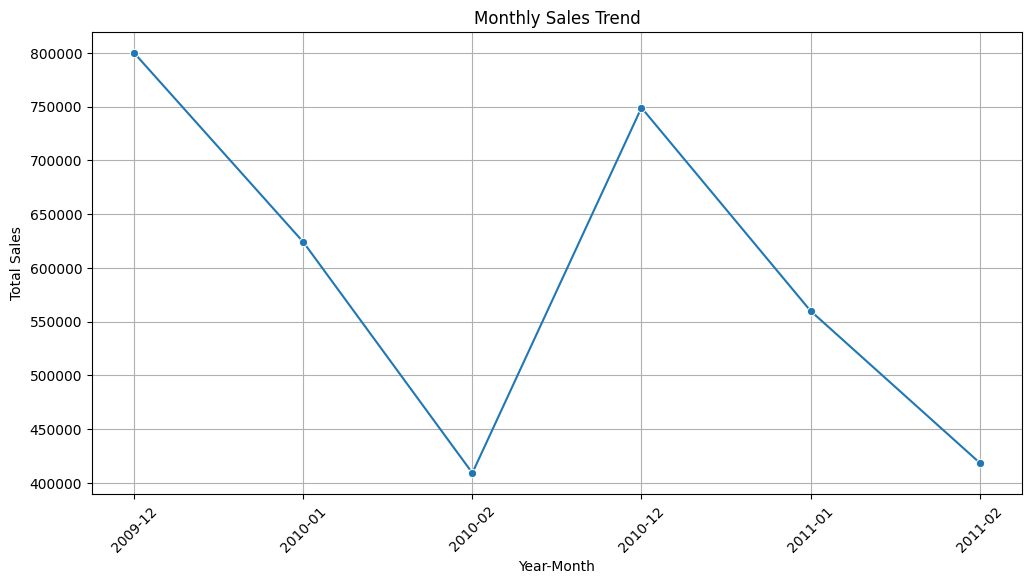

In [7]:
f_data['InvoiceDate'] = pd.to_datetime(f_data['InvoiceDate'], errors='coerce')
f_data['Quantity'] = pd.to_numeric(f_data['Quantity'], errors='coerce')
f_data['UnitPrice'] = pd.to_numeric(f_data['UnitPrice'], errors='coerce')
f_data = f_data.dropna(subset=['InvoiceDate', 'Quantity', 'UnitPrice'])
f_data['TotalSales'] = f_data['Quantity'] * f_data['UnitPrice']
f_data['YearMonth'] = f_data['InvoiceDate'].dt.to_period('M')
monthly_sales = f_data.groupby('YearMonth')['TotalSales'].sum()
monthly_sales = monthly_sales.reset_index()
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)
plt.figure(figsize=(12,6))
sns.lineplot(x='YearMonth', y='TotalSales', data=monthly_sales, marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [19]:
print(f_data.columns)
f_data.columns = f_data.columns.str.strip()

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [24]:
f_data = pd.read_csv('online_retail_combined.csv', encoding='latin1')
f_data['InvoiceDate'] = pd.to_datetime(f_data['InvoiceDate'], errors='coerce')
f_data = f_data.dropna(subset=['Customer ID'])
f_data['Customer ID'] = f_data['Customer ID'].astype(int)
f_data['TotalSales'] = f_data['Quantity'] * f_data['Price']
f_data = f_data[(f_data['Quantity'] > 0) & (f_data['TotalSales'] > 0)]

In [26]:
snapshot_date = f_data['InvoiceDate'].max()
rfm = f_data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'StockCode': 'nunique',
    'TotalSales': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346,36,3,77387.10
12347,27,49,1187.18
12348,29,18,1120.24
12350,20,17,334.40
12352,7,15,296.50


In [27]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)


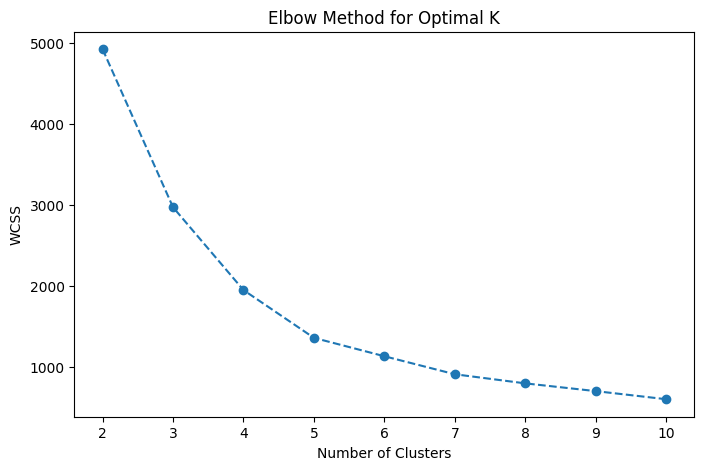

In [28]:
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

In [29]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm['Cluster'].value_counts()


,count
Cluster,
1,1374
0,902
3,222
2,6


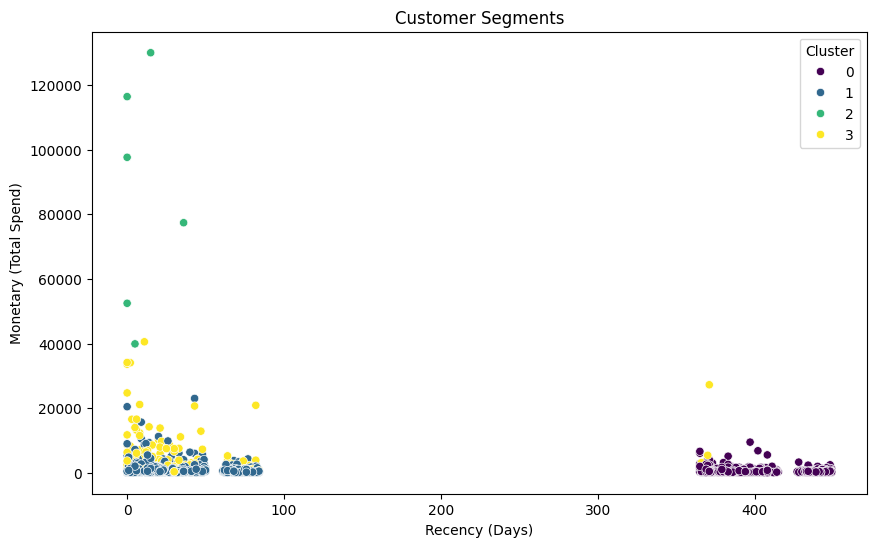

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'], hue=rfm['Cluster'], palette='viridis')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary (Total Spend)')
plt.title('Customer Segments')
plt.legend(title='Cluster')
plt.show()
